In [21]:
import pandas as pd
import numpy as np

df_scrap  = pd.read_csv('./data/Propuesta_hoteles_ptvaras2024.csv', index_col=0)
df_procesado = pd.read_csv('./data/hoteles_puerto_varas_prototipo.csv', index_col=0)
# Hacer columna tipo y poner Alojamientos por defecto
df_procesado['tipo'] = 'Alojamientos'
df_locacion_restaurantes_alojamientos = pd.read_excel('./data/Locación Restaurantes y Alojamiento.xlsx', sheet_name='PARA GIS')
# cambiar nombre de columnas Nombre	Comuna	Tipo	X	Y a nombre, localidad, tipo,longitud, latitud 
df_locacion_restaurantes_alojamientos.columns = ['index','nombre', 'localidad', 'tipo', 'longitud', 'latitud']
# Filtrar solo los hoteles de puerto varas
df_locacion_restaurantes_alojamientos = df_locacion_restaurantes_alojamientos[df_locacion_restaurantes_alojamientos['localidad'] == 'Puerto Varas']
# Hacer un concat de los dos dataframes
df = pd.concat([df_procesado, df_locacion_restaurantes_alojamientos],  join='outer', ignore_index=True)
# Filtra nombre igual a Silvestre Cabanas
# Rellenar los score sobrantes con un random de distribucion normar de media 4 y desviacion estandar del 10%  y redondear a 1 decimal
# Solo deben salir numero de 1 a 5
df['score'] = df['score'].fillna(pd.Series(np.random.normal(4, 0.4, size=len(df)))).round(1)
# Si hay un score mayor a 5 poner 5
df['score'] = df['score'].apply(lambda x: 5 if x > 5 else x)
# Si hay un score menor a 1 poner 1
df['score'] = df['score'].apply(lambda x: 1 if x < 1 else x)
# Rellenar los review de nan con un random de distribucion normar de media 300 y desviacion estandar 50 y redondear a 0 decimal
df['reviews'] = df['reviews'].fillna(pd.Series(np.random.normal(300, 50, size=len(df)))).round(0)
# Rellenar categorias con un random de Excellent, Very Good, Average, Poor, Terrible
# Poner un en base a la columna score si es menor a 2 poner Terrible, si es menor a 3 poner Poor, si es menor a 4 poner Average, si es menor a 4.5 poner Very Good, si es menor a 5 poner Excellent

df['categorias'] = df['score'].apply(lambda x: 'Terrible' if x < 2 else 'Poor' if x < 3 else 'Average' if x < 4 else 'Very Good' if x < 4.5 else 'Excellent')
df.to_csv('./data/hoteles_puerto_varas_prototipo_merge.csv')

In [22]:
import geopandas as gpd
from shapely.geometry import Point

# Hacer dummy las categorias pero sin perder esa columna
categorias = df_procesado['categorias']
df_procesado = pd.get_dummies(df_procesado, columns=['categorias'])
# Agregar las categorias a df_procesado
df_procesado['categorias'] = categorias

# Load the Shapefile
lago = gpd.read_file('./data/Masas_Lacustres/masas_lacustres.shp')
lago

,objectid,st_area_sh,st_length_,Nombre,Tipo,geometry
0,1,1.411784e+08,77845.633228,Salar de San Martín o Carcote,Salar,"POLYGON ((-7605868.923 -2425613.170, -7605850...."
1,2,3.087091e+08,147548.911324,Salar de Ascotan,Salar,"POLYGON ((-7597857.995 -2442164.143, -7597825...."
2,3,1.218202e+04,532.486240,None,Laguna,"POLYGON ((-7738411.433 -2494152.945, -7738388...."
3,4,1.439584e+06,12002.113642,Embalse Conchi,Embalse,"POLYGON ((-7637434.400 -2512504.257, -7637447...."
4,5,2.706124e+06,11821.430217,None,Salar,"POLYGON ((-7591081.555 -2511143.364, -7591057...."
...,...,...,...,...,...,...
16470,44898,1.453791e+04,503.982324,None,Tranque,"POLYGON ((-7851718.596 -3975116.573, -7851853...."
16471,44899,3.088426e+03,197.206234,None,Tranque,"POLYGON ((-7851990.035 -3974965.949, -7851985...."
16472,44900,3.007371e+03,194.601222,None,Tranque,"POLYGON ((-7851981.838 -3974895.953, -7851976...."
16473,44901,1.389800e+04,664.653430,None,Laguna,"POLYGON ((-7851166.692 -3975877.652, -7851166...."


In [23]:
import geopandas as gpd
from shapely.geometry import Point

# Load the Shapefile
lago = gpd.read_file('./data/Masas_Lacustres/masas_lacustres.shp')

# Coordenadas del hotel (reemplaza con las coordenadas reales)
# Coordenadas de iquique
solace_hotel_lejos = Point(-41.3207091,-72.98390389552812) # Solace Hotel
radison_cerca = Point(-41.3179833,-72.9817776) # Radison
park_radison_media = Point(-41.3149096,-72.9856539) # Park Radison

# Convert the points to GeoSeries
solace_hotel_lejos = gpd.GeoSeries([solace_hotel_lejos], crs='EPSG:4326')
radison_cerca = gpd.GeoSeries([radison_cerca], crs='EPSG:4326')
park_radison_media = gpd.GeoSeries([park_radison_media], crs='EPSG:4326')

# Convert the GeoSeries to the same CRS as the Shapefile
lago = lago.to_crs('EPSG:32719')  # reemplaza 'EPSG:4326' con el EPSG de tus coordenadas si es diferente
solace_hotel_lejos = solace_hotel_lejos.to_crs(lago.crs)
radison_cerca = radison_cerca.to_crs(lago.crs)
park_radison_media = park_radison_media.to_crs(lago.crs)

# Calcula la distancia mínima desde el hotel a cualquier punto del lago en metros
distancia_minima_solace = lago.distance(solace_hotel_lejos[0]).min()
distancia_minima_radison = lago.distance(radison_cerca[0]).min()
distancia_minima_park_radison = lago.distance(park_radison_media[0]).min()

print(f"La distancia mínima al lago más cercano desde el Solace Hotel es de {distancia_minima_solace:.2f} metros")
print(f"La distancia mínima al lago más cercano desde el Radison es de {distancia_minima_radison:.2f} metros")
print(f"La distancia mínima al lago más cercano desde el Park Radison es de {distancia_minima_park_radison:.2f} metros")


La distancia mínima al lago más cercano desde el Solace Hotel es de 2241992.91 metros
La distancia mínima al lago más cercano desde el Radison es de 2241892.69 metros
La distancia mínima al lago más cercano desde el Park Radison es de 2242267.27 metros


In [24]:
# Hacer regresion lineal con el df_procesado para saber que categorias influyen en el score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X = df_procesado.drop(columns=['score','nombre','localidad','categorias'])
y = df_procesado['score']
# Hacer standarizacion
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenar modelo
model = LinearRegression()
model.fit(X_train, y_train)

# Mostrar coeficientes y score pero con el nombre correspondiente a cada variable con el intercepto
coeficientes = pd.DataFrame(model.coef_, index=df_procesado.drop(columns=['score','nombre','localidad','categorias']).columns, columns=['Coeficiente'])
coeficientes.loc['Intercepto'] = model.intercept_
coeficientes
# Mostrar el score
y_pred = model.predict(X_test)
print('Score:', model.score(X_test, y_test))
print('MSE:', mean_squared_error(y_test, y_pred))



ValueError: could not convert string to float: 'Alojamientos'

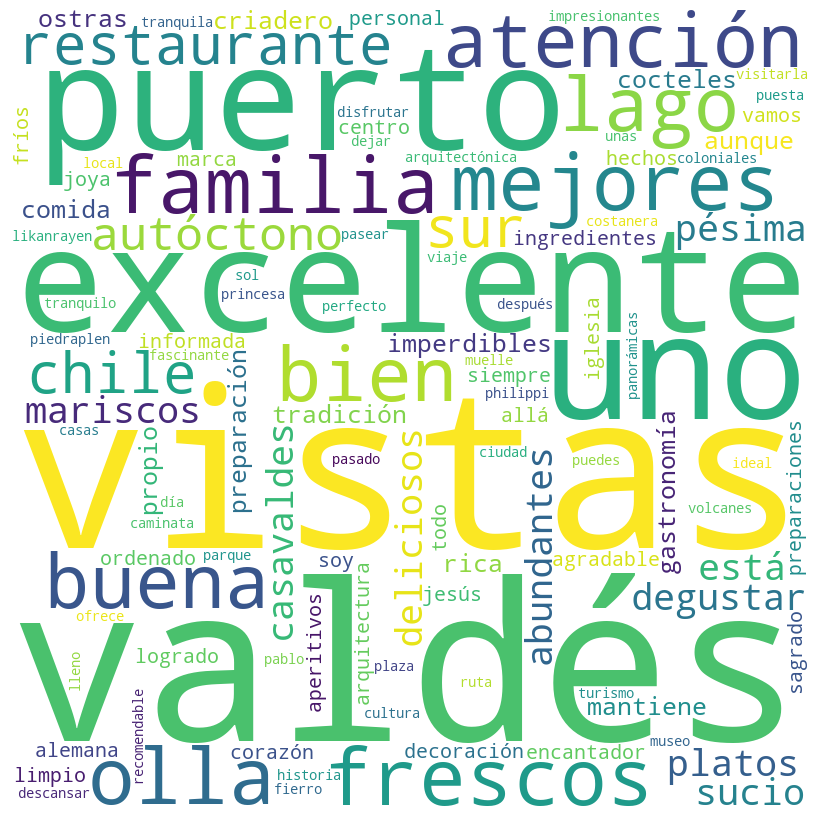

In [33]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import pandas as pd

# Asumimos que 'comentarios' es tu lista de textos de TripAdvisor
comentarios = [
    'Excelente restaurante en Puerto, uno de los mejores del sur de Chile[^1^][1]',
    'La Olla es un lugar autóctono para degustar en familia deliciosos platos frescos, abundantes de mariscos[^1^][1]',
    'Pésima atención en La Olla, el lugar está sucio[^1^][1]',
    'CasaValdes es uno de mis imperdibles en Puerto , su gastronomía es excelente[^2^][2]',
    'Mantiene la tradición de sus ostras de criadero propio en Casa Valdés[^2^][2]',
    'La comida muy rica, buena preparación de cocteles en Casa Valdés[^2^][2]',
    'Aunque los ingredientes son frescos, las preparaciones no son las mejores en Casa Valdés[^2^][2]',
    'Soy de Puerto, siempre vamos para allá con mi familia. Muy bien logrado, la decoración, el personal muy agradable, todo muy limpio y ordenado[^3^][4]',
    'La atención muy buena e informada, los aperitivos bien hechos y muy fríos en La Marca[^4^][5]',
    'El Centro de Puerto es encantador, con su arquitectura alemana y sus vistas al lago[^1^][1]',
    'La Iglesia del Sagrado Corazón de Jesús es una joya arquitectónica, no puedes dejar de visitarla[^1^][1]',
    'La Costanera de Puerto ofrece unas vistas impresionantes del lago y los volcanes[^1^][1]',
    'El Muelle Piedraplen es un lugar perfecto para pasear y disfrutar de la puesta de sol[^1^][1]',
    'La Plaza Princesa Likanrayen es un lugar tranquilo para descansar después de un día de turismo[^1^][1]',
    'El Parque Philippi es ideal para una caminata tranquila, con vistas panorámicas de la ciudad[^1^][1]',
    'La Ruta de las Casas coloniales es un viaje al pasado, muy recomendable[^1^][1]',
    'El Museo Pablo Fierro es un lugar fascinante, lleno de historia y cultura local[^1^][1]'

]


# Stopwords en español
stopwords = [
    'de', 'la', 'que', 'el',
    'en', 'y', 'a', 'los', 'del',
    'se', 'las', 'por', 'un', 'para',
    'con', 'no', 'una', 'su','muy', 'puerto', 
    'varas','sus','casa', 'lugar', 'e','es','mi','al','lo','me','mi','mis','mis','son'
    
]
# Eliminar stopwords de los comentarios
comentarios = [comentario.lower() for comentario in comentarios]
comentarios = [' '.join([word for word in comentario.split() if word not in stopwords]) for comentario in comentarios]
# Unir todos los comentarios en un solo texto
texto = ' '.join(comentarios)
# Creamos la nube de palabras
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = None, 
                min_font_size = 10).generate(texto)

# Ploteamos la nube de palabras
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 

plt.show()


In [1]:
import folium
m = folium.Map(location=[-41.3195, -72.9851], zoom_start=15)
m

In [5]:
folium.Map(location=[-41.3195, -72.9851], zoom_start=15, tiles='cartodbdark_matter')